## Import dependencies

In [1]:
import pandas as pd
import sqlite3
import gc
import cudf
import cugraph as cg

# ============================================
# CONFIGURATION: Set your target topic here
# ============================================
TARGET_TOPICS = ['T10078', 'T10001']  # List of topics to analyze (can contain multiple topics)

def clear_gpu_memory():
    """Clear GPU memory to avoid OOM errors"""
    gc.collect()
    try:
        import cupy as cp
        cp.get_default_memory_pool().free_all_blocks()
        print("✓ GPU memory cleared")
    except:
        pass

## Loading Citation-Paper Datasets

In [2]:
# Connect to the SQLite database file
conn = sqlite3.connect("data/openalex_works.db")

In [ ]:
### Table Name = 'works'
# MEMORY OPTIMIZATION: Load only the target topics from database
# This reduces initial memory load significantly

# Build SQL query for multiple topics
if len(TARGET_TOPICS) == 1:
    topic_filter = f"WHERE topic = '{TARGET_TOPICS[0]}'"
else:
    topic_list = "', '".join(TARGET_TOPICS)
    topic_filter = f"WHERE topic IN ('{topic_list}')"

print(f"Loading papers for topic(s): {TARGET_TOPICS}...")
topic_df = pd.read_sql_query(f"""
    SELECT *
    FROM works
    {topic_filter}
    """,
    conn
)
print(f"Loaded {len(topic_df)} papers for topic(s) {TARGET_TOPICS}")
print(topic_df.head())
topic_df.info()

Loading papers for topic(s): ['T10078', 'T10001']...
Loaded 82303 papers for topic(s) ['T10078', 'T10001']
            id                            doi  \
0  W2138522501  10.1144/gsl.sp.1989.042.01.19   
1  W2110540540            10.1021/cr00033a004   
2  W2150399639               10.1038/nmat2317   
3  W2091633783              10.1021/cr0500535   
4  W2039475059               10.1039/b800489g   

                                               title  apc_list_price   topic  \
0  Chemical and isotopic systematics of oceanic b...             NaN  T10001   
1  Environmental Applications of Semiconductor Ph...             NaN  T10078   
2  A metal-free polymeric photocatalyst for hydro...         11690.0  T10078   
3  Titanium Dioxide Nanomaterials:  Synthesis, Pr...             NaN  T10078   
4  Heterogeneous photocatalyst materials for wate...             NaN  T10078   

   referenced_works_count                                   referenced_works  \
0                     115  ["W2058382

In [ ]:
print("Reference works type:",type(topic_df["referenced_works"][0]))
print("Reference works count type:", type(topic_df["referenced_works_count"][0]))
print("Authors type:", type(topic_df["authors"][0]))

print()
print("###############################")
print(f"Dataset info for topic {TARGET_TOPICS}:")
topic_df.info()

Reference works type: <class 'str'>
Reference works count type: <class 'numpy.int64'>
Authors type: <class 'str'>

###############################
Dataset info for topic ['T10181']:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11400 non-null  object 
 1   doi                     8484 non-null   object 
 2   title                   11398 non-null  object 
 3   apc_list_price          1202 non-null   float64
 4   topic                   11400 non-null  object 
 5   referenced_works_count  11400 non-null  int64  
 6   referenced_works        11400 non-null  object 
 7   authors                 11400 non-null  object 
 8   cited_by_count          11400 non-null  int64  
 9   publication_date        11400 non-null  object 
 10  related_works           11400 non-null  object 
dtypes: float64(1), 

## Dataset Summary

This significantly reduces memory usage, especially important for GPU operations.
**Memory Optimization**: Data is filtered at SQL query level to load only the target topic.

In [ ]:
# Verify dataset
topic_display = ', '.join(TARGET_TOPICS)
print(f"\n{'='*60}")
print(f"TOPIC ANALYSIS: {topic_display}")
print(f"{'='*60}")
print(f"Total papers in topic(s): {len(topic_df)}")
print(f"Total citations: {topic_df['cited_by_count'].sum()}")
print(f"Average citations per paper: {topic_df['cited_by_count'].mean():.2f}")


TOPIC ANALYSIS: T10181
Total papers in topic(s): 11400
Total citations: 1956579
Average citations per paper: 171.63


## Build Paper Network

In [10]:
import ast
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Build a citation edge list from the existing `df`, run CuGraph PageRank,
# compute PageRank and degree, and show top results.


# 1) Parse referenced_works into Python lists (handles already-list objects or JSON-like strings)
def parse_list_cell(x):
    if x is None:
        return []
    if isinstance(x, (list, tuple)):
        return list(x)
    try:
        return ast.literal_eval(x)
    except Exception:
        # fallback: try to strip and split (very defensive)
        s = str(x).strip()
        if s.startswith("[") and s.endswith("]"):
            s = s[1:-1].strip()
        if not s:
            return []
        return [e.strip().strip('"').strip("'") for e in s.split(",") if e.strip()]
    
topic_df['referenced_works_parsed'] = topic_df['referenced_works'].apply(parse_list_cell)

# 2) Create an edge list DataFrame (source -> referenced_work)
# OPTIMIZED: Pre-compute set of valid IDs for O(1) lookup
valid_ids = set(topic_df['id'].values)
edges = [
    (src, dst) 
    for src, refs in zip(topic_df['id'], topic_df['referenced_works_parsed'])
    for dst in refs
    if dst and dst in valid_ids  # Combined check: non-empty AND in valid set
]

edges_df = pd.DataFrame(edges, columns=['source', 'target'])
print(f"Built {len(edges_df)} edges")

Built 80263 edges


In [11]:
print(topic_df.head(2)[["referenced_works_parsed", "referenced_works"]])
print("######################################################################")
print(edges_df.head())

                             referenced_works_parsed  \
0                                                 []   
1  [W202303397, W1983607152, W1746680969, W212616...   

                                    referenced_works  
0                                                 []  
1  ["W202303397", "W1983607152", "W1746680969", "...  
######################################################################
        source       target
0  W1880262756    W15201044
1  W2157331557  W2117278770
2  W2157331557  W1905522558
3  W2157331557  W2161792612
4  W2157331557    W22168010


## 1. Running PageRank on Topic Paper Network

In [ ]:
# cuGraph (GPU) - Memory-efficient graph construction
# All operations limited to topic(s): {TARGET_TOPICS}

topic_display = ', '.join(TARGET_TOPICS)
print(f"\n{'='*60}")
print(f"GPU GRAPH CONSTRUCTION (Topic(s): {topic_display})")
print(f"{'='*60}")

if len(edges_df) > 0:
    # convert pandas edges_df to cudf
    cudf_edges = cudf.from_pandas(edges_df.astype(str))  # ensure string dtype for ids
    # cuGraph expects numeric vertex IDs for many algorithms; create a mapping
    unique_vertices = cudf.concat([cudf_edges['source'], cudf_edges['target']]).unique()
    vid_df = unique_vertices.reset_index(drop=True).to_frame(name='vertex_id')
    vid_df['int_id'] = cudf.RangeIndex(len(vid_df))
    # join to get numeric src/dst columns
    cudf_edges = cudf_edges.merge(vid_df, left_on='source', right_on='vertex_id', how='left').rename(columns={'int_id':'src_id'}).drop(columns=['vertex_id'])
    cudf_edges = cudf_edges.merge(vid_df, left_on='target', right_on='vertex_id', how='left').rename(columns={'int_id':'dst_id'}).drop(columns=['vertex_id'])
    # build cuGraph Graph with store_transposed=True for optimal PageRank performance
    G_gpu = cg.Graph(directed=True)
    # from_cudf_edgelist: graph.from_cudf_edgelist(cudf_edges, source='src_id', destination='dst_id', edge_attr=None)
    try:
        G_gpu.from_cudf_edgelist(cudf_edges, source='src_id', destination='dst_id', edge_attr=None)
    except Exception:
        G_gpu.add_edge_list(cudf_edges['src_id'], cudf_edges['dst_id'], None)
    print("cuGraph nodes, edges (approx):", G_gpu.number_of_vertices(), G_gpu.number_of_edges())

    # PageRank on GPU (returns cudf DataFrame with vertex and pagerank)
    pr_df = cg.pagerank(G_gpu, alpha=0.85)
    
    # pr_df has numeric vertex ids; join back to original ids
    pr_df = pr_df.merge(vid_df, left_on='vertex', right_on='int_id', how='left')
    top_gpu_pr = pr_df.sort_values('pagerank', ascending=False).head(10)
    print("Top cuGraph PageRank (top 10):")
    print(top_gpu_pr[['vertex_id', 'pagerank']].to_pandas())

    # Degree (in-degree) using cuGraph Graph methods
    try:
        deg_df = G_gpu.in_degree()
        deg_df = deg_df.merge(vid_df, left_on='vertex', right_on='int_id', how='left')
        print("\nTop cuGraph in-degree (top 10):")
        print(deg_df.sort_values('degree', ascending=False).head(10)[['vertex_id','degree']].to_pandas())
    except Exception as e:
        print(f"cuGraph degree computation failed: {e}")
    
    # Clear intermediate data to save GPU memory
    print("\n✓ GPU graph constructed successfully")
    print("⚠️ Clearing intermediate data...")
    del cudf_edges  # Free GPU memory from edge construction
    clear_gpu_memory()
else:
    print("ℹ Skipping cuGraph analysis (GPU not available or no edges).")
    print("  NetworkX results above are still valid for CPU-based analysis.")


GPU GRAPH CONSTRUCTION (Topic(s): T10181)
cuGraph nodes, edges (approx): 9740 80263
Top cuGraph PageRank (top 10):
        vertex_id  pagerank
5493  W2061271742  0.011594
7218  W2006969979  0.011060
6558  W2124479173  0.010690
7216  W2101105183  0.007509
9011  W2334801970  0.006723
4835  W3037252522  0.006517
2357  W2048390999  0.005993
8260  W2007780422  0.005770
3216  W2117652747  0.005175
7217  W2038721957  0.004390

Top cuGraph in-degree (top 10):
        vertex_id  degree
9724  W2101105183     993
9725  W2038721957     479
9726  W2006969979     466
9727  W2124807415     456
9728  W4385245566     416
9729  W2156985047     387
9730  W2153653739     368
9731  W2147880316     356
9732  W2146574666     348
9733  W2092654472     280

✓ GPU graph constructed successfully
⚠️ Clearing intermediate data...
✓ GPU memory cleared


/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


### CPU Check

In [ ]:
import networkx as nx

# NetworkX (CPU) graph and analysis
G = nx.DiGraph()
G.add_edges_from(edges_df.itertuples(index=False, name=None))
print("NetworkX nodes, edges:", G.number_of_nodes(), G.number_of_edges())

# Basic metrics: degree and PageRank
nx_in_deg = dict(G.in_degree())
nx_out_deg = dict(G.out_degree())
nx_pagerank = nx.pagerank(G, alpha=0.85)

# Show top-10 by PageRank
top_nx_pr = sorted(nx_pagerank.items(), key=lambda kv: kv[1], reverse=True)[:10]
print("Top NetworkX PageRank (top 10):")
for node, score in top_nx_pr:
    print(node, score)

# Optional: small layout plot (only if graph small)
if G.number_of_nodes() <= 200:
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title("Citation network (NetworkX)")
    plt.axis('off')
    plt.show()

NetworkX nodes, edges: 9740 80263
Top NetworkX PageRank (top 10):
W2061271742 0.011660356582219202
W2006969979 0.011058350310793148
W2124479173 0.010863136322745031
W2101105183 0.007471250981658686
W2334801970 0.00681384504688578
W3037252522 0.006463291788670323
W2048390999 0.006096433007814779
W2007780422 0.00587392572976889
W2117652747 0.0052547571287419
W1571096757 0.004415381855765966


## 2. Convergence Properties

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Track PageRank convergence using cuGraph with safer approach
def pagerank_convergence_cugraph(G_gpu, vid_df, alpha=0.85, max_iter=100):
    """
    Compute PageRank using cuGraph and track convergence by running 
    the algorithm step by step, handling convergence failures gracefully.
    
    Returns:
        pr_final: Final PageRank scores (cudf DataFrame)
        convergence_history: List of total differences at each iteration
    """
    convergence_history = []
    pr_prev = None
    
    print(f"Running cuGraph PageRank with convergence tracking...")
    print(f"Graph: {G_gpu.number_of_vertices()} vertices, {G_gpu.number_of_edges()} edges")
    
    # Run PageRank iteratively, starting from a reasonable number of iterations
    # and catching convergence failures
    for iteration in range(1, max_iter + 1):
        try:
            # Run PageRank up to current iteration with fail_on_nonconvergence=False
            pr_result_raw = cg.pagerank(
                G_gpu, 
                alpha=alpha, 
                max_iter=iteration, 
                tol=0,  # Disable tolerance-based stopping
                fail_on_nonconvergence=False  # Returns tuple (df, converged_bool)
            )
            
            # Extract DataFrame from tuple if necessary
            if isinstance(pr_result_raw, tuple):
                pr_current = pr_result_raw[0]
            else:
                pr_current = pr_result_raw
            
            # Calculate difference from previous iteration
            if pr_prev is not None:
                # Merge on vertex to align scores
                merged = pr_prev.merge(pr_current, on='vertex', suffixes=('_prev', '_curr'))
                diff = (merged['pagerank_curr'] - merged['pagerank_prev']).abs().sum()
                convergence_history.append(float(diff))
                
                if iteration % 10 == 0 or iteration <= 5:
                    print(f"  Iteration {iteration}: diff = {diff:.8e}")
                
                # Check for convergence (early stopping)
                if diff < 1e-7 and iteration > 10:
                    print(f"✓ Converged after {iteration} iterations (diff = {diff:.8e})")
                    pr_final = pr_current
                    break
            
            pr_prev = pr_current.copy()
            
        except Exception as e:
            print(f"  Warning at iteration {iteration}: {str(e)[:100]}")
            if pr_prev is not None:
                pr_final = pr_prev
                break
            else:
                # If first iteration fails, try with more iterations
                print(f"  Retrying with more iterations...")
                try:
                    pr_final = cg.pagerank(G_gpu, alpha=alpha, max_iter=50, fail_on_nonconvergence=False)
                    convergence_history = []  # Reset history since we jumped ahead
                    break
                except:
                    raise
    else:
        pr_final = pr_current
        print(f"✓ Completed {max_iter} iterations")
    
    return pr_final, convergence_history

# Run PageRank with convergence tracking using cuGraph
if len(edges_df) > 0 and 'G_gpu' in dir():
    print(f"\n{'='*60}")
    print(f"CUGRAPH PAGERANK CONVERGENCE ANALYSIS")
    print(f"{'='*60}")
    
    pr_result, convergence_history = pagerank_convergence_cugraph(
        G_gpu,
        vid_df,
        alpha=0.85, 
        max_iter=100  
    )
    
    print(f"\n✓ Tracked {len(convergence_history)} iterations")
    
    # Show top PageRank scores
    # Handle case where pr_result might be a tuple (with convergence info)
    if isinstance(pr_result, tuple):
        pr_df_final = pr_result[0]
    else:
        pr_df_final = pr_result
    
    pr_with_ids = pr_df_final.merge(vid_df, left_on='vertex', right_on='int_id', how='left')
    top_pr = pr_with_ids.sort_values('pagerank', ascending=False).head(10)
    print("\nTop 10 PageRank scores:")
    print(top_pr[['vertex_id', 'pagerank']].to_pandas())
else:
    print("No edges to analyze or GPU graph not available")
    convergence_history = []


CUGRAPH PAGERANK CONVERGENCE ANALYSIS
Running cuGraph PageRank with convergence tracking...
Graph: 9740 vertices, 80263 edges


/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' f

  Iteration 2: diff = 3.00730646e-01
  Iteration 3: diff = 1.35989368e-01
  Iteration 4: diff = 7.11756125e-02
  Iteration 5: diff = 3.78038697e-02
  Iteration 10: diff = 1.48420455e-03
  Iteration 20: diff = 1.63925724e-05


/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' f

  Iteration 30: diff = 3.23156564e-06
  Iteration 40: diff = 6.49793947e-07
  Iteration 50: diff = 1.24855433e-07
✓ Converged after 51 iterations (diff = 9.17389116e-08)

✓ Tracked 50 iterations

Top 10 PageRank scores:
        vertex_id  pagerank
6289  W2061271742  0.011594
8654  W2006969979  0.011060
6746  W2124479173  0.010690
8652  W2101105183  0.007509
8323  W2334801970  0.006723
4911  W3037252522  0.006517
2133  W2048390999  0.005992
5744  W2007780422  0.005770
8556  W2117652747  0.005174
8653  W2038721957  0.004390


/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' f

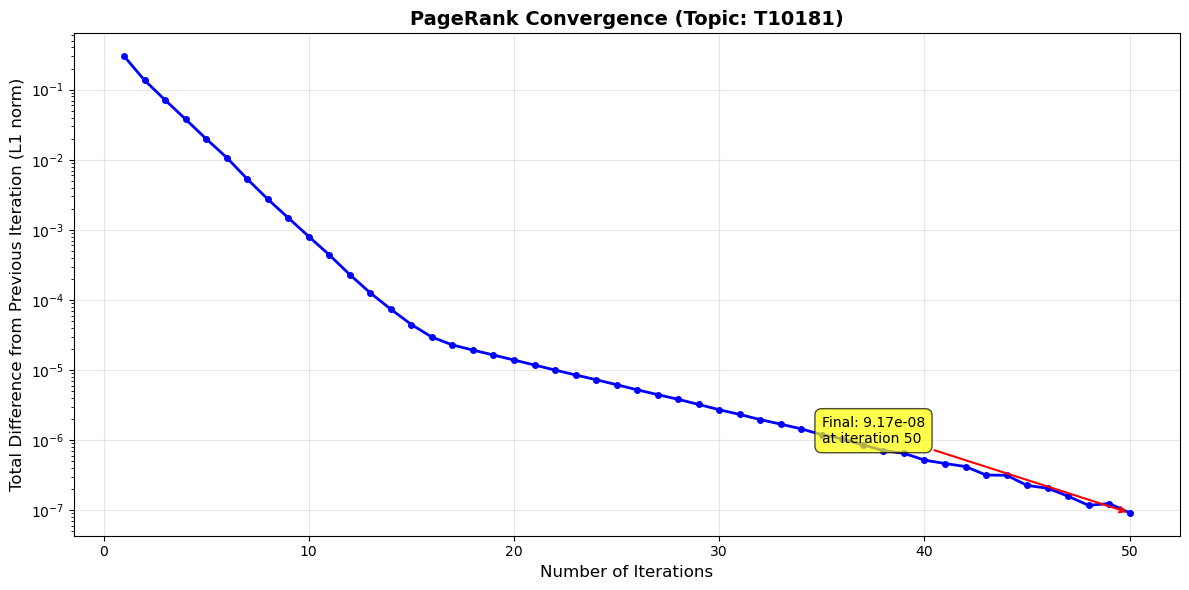


CONVERGENCE STATISTICS
Total iterations: 50
Initial difference: 0.30073065
Final difference: 0.00000009
Convergence rate: 3278114.38x improvement


In [ ]:
# Visualize PageRank convergence
if len(convergence_history) > 0:
    plt.figure(figsize=(12, 6))
    
    iterations = range(1, len(convergence_history) + 1)
    topic_display = ', '.join(TARGET_TOPICS)
    
    plt.plot(iterations, convergence_history, 'b-', linewidth=2, marker='o', markersize=4)
    plt.xlabel('Number of Iterations', fontsize=12)
    plt.ylabel('Total Difference from Previous Iteration (L1 norm)', fontsize=12)
    plt.title(f'PageRank Convergence (Topic(s): {topic_display})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale to better show convergence
    
    # Add annotation for final convergence
    final_iter = len(convergence_history)
    final_diff = convergence_history[-1]
    plt.annotate(f'Final: {final_diff:.2e}\nat iteration {final_iter}',
                xy=(final_iter, final_diff),
                xytext=(final_iter * 0.7, final_diff * 10),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"CONVERGENCE STATISTICS")
    print(f"{'='*60}")
    print(f"Total iterations: {len(convergence_history)}")
    print(f"Initial difference: {convergence_history[0]:.8f}")
    print(f"Final difference: {convergence_history[-1]:.8f}")
    print(f"Convergence rate: {(convergence_history[0] / convergence_history[-1]):.2f}x improvement")
else:
    print("No convergence data to plot")

## 3. Finding Relevant Papers

### 3.1. Seed Papers

In [12]:
# Choose papers based on the given list of IDs
seed_papers = [
    "W2626778328"
]

print(f"{'='*60}")
print(f"SEED PAPER SELECTION")
print(f"{'='*60}")
print(f"Selected {len(seed_papers)} seed papers:\n")
for i, paper_id in enumerate(seed_papers, 1):
    # Get paper info
    paper_info = topic_df[topic_df['id'] == paper_id]
    if not paper_info.empty:
        title = paper_info.iloc[0]['title']
        date = paper_info.iloc[0]['publication_date']
        citations = paper_info.iloc[0]['cited_by_count']
        print(f"{i}. {paper_id}")
        print(f"   Title: {title[:80]}...")
        print(f"   Year: {date}, Citations: {citations}")
    else:
        print(f"{i}. {paper_id} (not in topic dataset)")
    print()

SEED PAPER SELECTION
Selected 1 seed papers:

1. W2626778328
   Title: Attention Is All You Need...
   Year: 2025-08-23, Citations: 6466



### 3.2. Baseline 1: Co-Citation Count

In [13]:
# METHOD 1: Co-Citation Count
# Score = number of papers commonly cited by current paper and seed papers

print(f"{'='*60}")
print(f"METHOD 1: CO-CITATION COUNT")
print(f"{'='*60}")

# Get all papers cited by seed papers (union of references)
seed_citations = set()
for seed_id in seed_papers:
    seed_row = topic_df[topic_df['id'] == seed_id]
    if not seed_row.empty:
        refs = seed_row.iloc[0]['referenced_works_parsed']
        seed_citations.update(refs)

print(f"Seed papers cite {len(seed_citations)} unique papers in total\n")

# Calculate co-citation score for each paper in the dataset
cocitation_scores = []

print("Calculating co-citation scores...")
for idx, row in topic_df.iterrows():
    paper_id = row['id']
    
    # Skip if this is a seed paper
    if paper_id in seed_papers:
        continue
    
    # Get papers cited by this paper
    cited_by_paper = set(row['referenced_works_parsed'])
    
    # Calculate overlap with seed citations (co-citation count)
    common_citations = seed_citations.intersection(cited_by_paper)
    score = len(common_citations)
    
    if score > 0:  # Only keep papers with non-zero score
        cocitation_scores.append({
            'paper_id': paper_id,
            'cocitation_score': score,
            'title': row['title'],
            'date': row['publication_date'],
            'citations': row['cited_by_count']
        })
        
# Convert to DataFrame and sort by score
cocitation_df = pd.DataFrame(cocitation_scores)
cocitation_df = cocitation_df.sort_values('cocitation_score', ascending=False)

print(f"✓ Found {len(cocitation_df)} papers with non-zero co-citation scores")
print(f"\n{'='*60}")
print(f"TOP 10 PAPERS BY CO-CITATION COUNT")
print(f"{'='*60}\n")

for idx, row in cocitation_df.head(10).iterrows():
    print(f"Score: {row['cocitation_score']:3d} | {row['title'][:60]}...")
    print(f"             Date: {row['date']}, Citations: {row['citations']}")
    print(f"             ID: {row['paper_id']}")
    print()

METHOD 1: CO-CITATION COUNT
Seed papers cite 28 unique papers in total

Calculating co-citation scores...
✓ Found 1677 papers with non-zero co-citation scores

TOP 10 PAPERS BY CO-CITATION COUNT

Score:   8 | Dual Transfer Learning for Neural Machine Translation with M...
             Date: 2018-04-27, Citations: 77
             ID: W2785093437

Score:   8 | A Convolutional Encoder Model for Neural Machine Translation...
             Date: 2017-01-01, Citations: 428
             ID: W2552839021

Score:   8 | Neural Machine Translation with Deep Attention...
             Date: 2018-10-16, Citations: 124
             ID: W2897983179

Score:   8 | Learning Deep Transformer Models for Machine Translation...
             Date: 2019-01-01, Citations: 599
             ID: W2963542740

Score:   7 | How Much Attention Do You Need? A Granular Analysis of Neura...
             Date: 2018-01-01, Citations: 79
             ID: W2798761464

Score:   7 | Exploiting Deep Representations for Neural Mac

### 3.3. Personalized PageRank

In [14]:
# METHOD 2: Personalized PageRank (PPR)
# Computes PageRank with teleportation biased towards seed papers

print(f"{'='*60}")
print(f"METHOD 2: PERSONALIZED PAGERANK")
print(f"{'='*60}")

if 'G_gpu' in dir() and len(edges_df) > 0:
    # Create personalization vector for seed papers
    # Map seed paper IDs to their integer vertex IDs
    seed_int_ids = []
    for seed_id in seed_papers:
        match = vid_df[vid_df['vertex_id'] == seed_id]
        if len(match) > 0:
            seed_int_ids.append(int(match['int_id'].iloc[0]))
    
    print(f"Seed papers mapped to {len(seed_int_ids)} graph vertices")
    
    if len(seed_int_ids) > 0:
        # Create personalization DataFrame
        # Equal weight for all seed papers (uniform teleportation)
        personalization_weight = 1.0 / len(seed_int_ids)
        
        personalization_df = cudf.DataFrame({
            'vertex': seed_int_ids,
            'values': [personalization_weight] * len(seed_int_ids)
        })
        
        print(f"Personalization weights: {personalization_weight:.4f} per seed paper")
        print(f"\nRunning Personalized PageRank...")
        
        # Run Personalized PageRank
        ppr_result = cg.pagerank(
            G_gpu,
            alpha=0.85,  # Damping factor
            personalization=personalization_df,
            max_iter=100,
            tol=1e-6
        )
        
        # Handle tuple return (df, converged) if fail_on_nonconvergence is used
        if isinstance(ppr_result, tuple):
            ppr_df = ppr_result[0]
        else:
            ppr_df = ppr_result
        
        # Map back to original vertex IDs
        ppr_df = ppr_df.merge(vid_df, left_on='vertex', right_on='int_id', how='left')
        
        # Exclude seed papers from results
        seed_set = set(seed_papers)
        ppr_df_filtered = ppr_df[~ppr_df['vertex_id'].isin(seed_set)]
        
        # Sort by PPR score
        top_ppr = ppr_df_filtered.sort_values('pagerank', ascending=False).head(20)
        top_ppr_pandas = top_ppr[['vertex_id', 'pagerank']].to_pandas()
        
        print(f"\n✓ Personalized PageRank completed")
        print(f"\n{'='*60}")
        print(f"TOP 10 PAPERS BY PERSONALIZED PAGERANK")
        print(f"{'='*60}\n")
        
        # Display results with paper metadata
        for idx, (_, row) in enumerate(top_ppr_pandas.head(10).iterrows(), 1):
            paper_id = row['vertex_id']
            ppr_score = row['pagerank']
            
            # Get paper metadata
            paper_info = topic_df[topic_df['id'] == paper_id]
            if not paper_info.empty:
                title = paper_info.iloc[0]['title']
                date = paper_info.iloc[0]['publication_date']
                citations = paper_info.iloc[0]['cited_by_count']
                print(f"{idx:2d}. PPR Score: {ppr_score:.6f}")
                print(f"    Title: {title[:65]}...")
                print(f"    Date: {date}, Citations: {citations}")
            else:
                print(f"{idx:2d}. PPR Score: {ppr_score:.6f} | {paper_id}")
            print()
        
        # Store results for comparison
        ppr_rankings = top_ppr_pandas.copy()
        ppr_rankings.columns = ['paper_id', 'ppr_score']
        
        print(f"{'='*60}")
        print(f"PPR STATISTICS")
        print(f"{'='*60}")
        print(f"Max PPR score: {ppr_df['pagerank'].max():.6f}")
        print(f"Min PPR score: {ppr_df['pagerank'].min():.8f}")
        print(f"Mean PPR score: {ppr_df['pagerank'].mean():.8f}")
        
    else:
        print("⚠️ No seed papers found in the graph")
else:
    print("⚠️ GPU graph not available. Please run the graph construction cell first.")

METHOD 2: PERSONALIZED PAGERANK
Seed papers mapped to 1 graph vertices
Personalization weights: 1.0000 per seed paper

Running Personalized PageRank...

✓ Personalized PageRank completed

TOP 10 PAPERS BY PERSONALIZED PAGERANK

 1. PPR Score: 0.027604
    Title: Effective self-training for parsing...
    Date: 2006-01-01, Citations: 615

 2. PPR Score: 0.026603
    Title: Effective Approaches to Attention-based Neural Machine Translatio...
    Date: 2015-01-01, Citations: 8413

 3. PPR Score: 0.026252
    Title: Deep Recurrent Models with Fast-Forward Connections for Neural Ma...
    Date: 2016-12-01, Citations: 223

 4. PPR Score: 0.025883
    Title: Self-training PCFG grammars with latent annotations across langua...
    Date: 2009-01-01, Citations: 87

 5. PPR Score: 0.025749
    Title: Learning accurate, compact, and interpretable tree annotation...
    Date: 2006-01-01, Citations: 808

 6. PPR Score: 0.025050
    Title: Fast and Accurate Shift-Reduce Constituent Parsing...
    Dat

/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:216: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/poppy/miniconda3/envs/citation-env/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:60: UserWarning: PageRank requires 'personalization' values to match the graph's 'edge_attr' type. edge_attr type is: <class 'numpy.float32'> and got 'personalization' values of type: float64.
  warnings.warn(warning_msg, UserWarning)


## 4. Paper Search

### 4.1. Setup

In [20]:
import re
from collections import Counter

# Define search query
SEARCH_QUERY = "attention"

def tokenize_query(query):
    """Tokenize and normalize a search query into keywords."""
    # Convert to lowercase and split on non-alphanumeric characters
    words = re.findall(r'\b[a-zA-Z0-9]+\b', query.lower())
    # Remove common stop words
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were'}
    return [w for w in words if w not in stop_words and len(w) > 1]

def count_keyword_matches(title, keywords):
    """Count how many keywords appear in a title."""
    if title is None or pd.isna(title):
        return 0
    title_lower = title.lower()
    title_words = set(re.findall(r'\b[a-zA-Z0-9]+\b', title_lower))
    return sum(1 for kw in keywords if kw in title_words)

# Parse search query
search_keywords = tokenize_query(SEARCH_QUERY)
print(f"{'='*60}")
print(f"PAPER SEARCH SETUP")
print(f"{'='*60}")
print(f"Search query: '{SEARCH_QUERY}'")
print(f"Keywords extracted: {search_keywords}")
print(f"Total papers to search: {len(topic_df)}")

PAPER SEARCH SETUP
Search query: 'attention'
Keywords extracted: ['attention']
Total papers to search: 11400


### 4.2. Baseline: Keyword Match Count

In [21]:
# BASELINE: Keyword Match Count
# Score = number of query keywords that appear in the paper title

print(f"{'='*60}")
print(f"BASELINE: KEYWORD MATCH COUNT")
print(f"{'='*60}")

# Calculate keyword match scores for all papers
keyword_scores = []

for idx, row in topic_df.iterrows():
    paper_id = row['id']
    title = row['title']
    score = count_keyword_matches(title, search_keywords)
    
    if score > 0:  # Only keep papers with at least one match
        keyword_scores.append({
            'paper_id': paper_id,
            'keyword_score': score,
            'title': title,
            'date': row['publication_date'],
            'citations': row['cited_by_count']
        })

# Convert to DataFrame and sort
keyword_df = pd.DataFrame(keyword_scores)
keyword_df = keyword_df.sort_values('keyword_score', ascending=False)

print(f"\n✓ Found {len(keyword_df)} papers with matching keywords")
print(f"\n{'='*60}")
print(f"TOP 10 PAPERS BY KEYWORD MATCH COUNT")
print(f"{'='*60}\n")

for idx, (_, row) in enumerate(keyword_df.head(10).iterrows(), 1):
    print(f"{idx:2d}. Score: {row['keyword_score']}/{len(search_keywords)} keywords matched")
    print(f"    Title: {row['title'][:65]}...")
    print(f"    Date: {row['date']}, Citations: {row['citations']}")
    print(f"    ID: {row['paper_id']}")
    print()

# Store baseline results
baseline_rankings = keyword_df[['paper_id', 'keyword_score']].copy()

BASELINE: KEYWORD MATCH COUNT

✓ Found 68 papers with matching keywords

TOP 10 PAPERS BY KEYWORD MATCH COUNT

 1. Score: 1/1 keywords matched
    Title: Effective Approaches to Attention-based Neural Machine Translatio...
    Date: 2015-01-01, Citations: 8413
    ID: W1902237438

 2. Score: 1/1 keywords matched
    Title: Attention Is All You Need...
    Date: 2025-08-23, Citations: 6466
    ID: W2626778328

 3. Score: 1/1 keywords matched
    Title: Analyzing Multi-Head Self-Attention: Specialized Heads Do the Hea...
    Date: 2019-01-01, Citations: 972
    ID: W2946794439

 4. Score: 1/1 keywords matched
    Title: DiSAN: Directional Self-Attention Network for RNN/CNN-Free Langua...
    Date: 2018-04-27, Citations: 729
    ID: W2964189376

 5. Score: 1/1 keywords matched
    Title: Language to Logical Form with Neural Attention...
    Date: 2016-01-01, Citations: 638
    ID: W2963794306

 6. Score: 1/1 keywords matched
    Title: Deep Biaffine Attention for Neural Dependency Parsing

### 4.3. Search with PageRank

In [22]:
# PAGERANK SEARCH
# Step 1: Filter papers by keyword match threshold
# Step 2: Sort accepted papers by PageRank score

print(f"{'='*60}")
print(f"PAGERANK SEARCH")
print(f"{'='*60}")

# Set minimum keyword match threshold
KEYWORD_THRESHOLD = 1  # Papers must match at least this many keywords

if 'pr_df' in dir() and len(keyword_df) > 0:
    # Step 1: Filter papers above keyword threshold
    accepted_papers = keyword_df[keyword_df['keyword_score'] >= KEYWORD_THRESHOLD].copy()
    print(f"Keyword threshold: {KEYWORD_THRESHOLD}")
    print(f"Papers passing keyword filter: {len(accepted_papers)}")
    
    # Get PageRank scores
    pr_pandas = pr_df[['vertex_id', 'pagerank']].to_pandas()
    pr_pandas = pr_pandas.rename(columns={'vertex_id': 'paper_id', 'pagerank': 'pr_score'})
    
    # Step 2: Merge with PageRank and sort by PageRank
    pagerank_results = accepted_papers.merge(pr_pandas, on='paper_id', how='left')
    pagerank_results['pr_score'] = pagerank_results['pr_score'].fillna(0)
    pagerank_results = pagerank_results.sort_values('pr_score', ascending=False)
    
    print(f"\n{'='*60}")
    print(f"TOP 10 PAPERS BY PAGERANK (Keyword Filtered)")
    print(f"{'='*60}\n")
    
    for idx, (_, row) in enumerate(pagerank_results.head(10).iterrows(), 1):
        print(f"{idx:2d}. PageRank: {row['pr_score']:.6f} | Keywords: {row['keyword_score']}/{len(search_keywords)}")
        print(f"    Title: {row['title'][:65]}...")
        print(f"    Date: {row['date']}, Citations: {row['citations']}")
        print(f"    ID: {row['paper_id']}")
        print()
    
    # Compare with baseline
    print(f"{'='*60}")
    print(f"RANKING COMPARISON: Baseline vs PageRank")
    print(f"{'='*60}\n")
    
    baseline_top10 = keyword_df.head(10)['paper_id'].tolist()
    pagerank_top10 = pagerank_results.head(10)['paper_id'].tolist()
    
    print("Position | Baseline (by keyword count) | PageRank (sorted by authority)")
    print("-" * 70)
    for i in range(10):
        base_id = baseline_top10[i] if i < len(baseline_top10) else "N/A"
        pr_id = pagerank_top10[i] if i < len(pagerank_top10) else "N/A"
        match = "✓" if base_id == pr_id else ""
        print(f"   {i+1:2d}    | {base_id:15s} | {pr_id:15s} {match}")
else:
    print("⚠️ PageRank data not available. Please run the PageRank cell first.")

PAGERANK SEARCH
Keyword threshold: 1
Papers passing keyword filter: 68

TOP 10 PAPERS BY PAGERANK (Keyword Filtered)

 1. PageRank: 0.001169 | Keywords: 1/1
    Title: Effective Approaches to Attention-based Neural Machine Translatio...
    Date: 2015-01-01, Citations: 8413
    ID: W1902237438

 2. PageRank: 0.000215 | Keywords: 1/1
    Title: Attention Is All You Need...
    Date: 2025-08-23, Citations: 6466
    ID: W2626778328

 3. PageRank: 0.000138 | Keywords: 1/1
    Title: Deep Biaffine Attention for Neural Dependency Parsing...
    Date: 2016-11-04, Citations: 551
    ID: W2963571341

 4. PageRank: 0.000115 | Keywords: 1/1
    Title: Language to Logical Form with Neural Attention...
    Date: 2016-01-01, Citations: 638
    ID: W2963794306

 5. PageRank: 0.000111 | Keywords: 1/1
    Title: The AMU-UEDIN Submission to the WMT16 News Translation Task: Atte...
    Date: 2016-01-01, Citations: 56
    ID: W2400065810

 6. PageRank: 0.000097 | Keywords: 1/1
    Title: Agreement-Based J